# Aufgabe 3

Folgende Teilaufgaben beschreiben die Fragestellungen. Untersuchen Sie die Art der Variablen und die Verteilung der Zielvariablen. Gegebenenfalls ist eine Datenvorverarbeitung nötig. Nennen Sie die möglichen Methoden. Wählen Sie eine Methode aus und begründen Sie Ihre Auswahl. Bitte separieren Sie die Datensätze mit 80% : 20% = Training : Test und führen Sie die Methode ohne Parameteroptimierung aus. Vergleichen Sie die Ergebnisse mit denen von vorgegebenen Methode(n).

a) Der Datensatz employment_08_09.xlsx beinhaltet die sozioökonomischen Daten der Arbeitskräfte in den USA im April 2008 und Angaben, ob sie im April 2009 weiterhin angestellt sind. Aller Befragten waren im April 2008 angestellt. Sagen Sie basierend auf den 2008er Informationen vorher, welche Arbeitskraft 2009 arbeitslos wird. Haben ältere Arbeitskräfte ein höheres Risiko für Arbeitslosigkeit während der Finanzkrise 2008-2009?
Baseline: Häufigste Klasse, lineare Regression.

b) Der Datensatz Growth.xlsx besteht aus dem Wachstum (Änderung des realen
Bruttoinlandsprodukts in Prozent) von 65 Ländern und Indikatoren, die theoretisch das Wachstum erklären könnten. Schätzen Sie das Wachstum der Länder im Test-Datensatz, basierend auf den Indikatoren.
Baseline: Das durchschnittliche Wachstum aller Länder.
Hinweis: Es gibt möglicherweise Dateninkonsistenz.

c) Welche Charakteristika eines weiblichen Krebses in crabs.txt finden männliche Krebs
(sogenannte Satellites auf Englisch) anziehend? Schätzen Sie die Anzahl der männlichen Krebse in Test-Datensatz anhand der Charakteristika der weiblichen Krebse.
Baseline: Poisson Regression.

d) Schätzen Sie den Anteil des Rohöls im Test-Datensatz, das in Gasolin konvertiert wird, anhand anderer Indikatoren im Datensatz gasoline.csv.
Baseline: Beta Regression.

### Imports

In [1]:
import pandas as pd
from statsmodels.othermod.betareg import BetaModel
from sklearn import linear_model, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 500)

# a)

### Read data

In [3]:
employment = pd.read_excel("dataset/employment_08_09.xlsx")
print(employment.shape)

(5412, 21)


In [4]:
employment.head()

,age,race,earnwke,employed,unemployed,married,union,ne_states,so_states,ce_states,we_states,government,private,self,educ_lths,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female
0,53,1,NaN,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
1,39,1,NaN,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
2,41,1,500.0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3,27,1,520.0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
4,29,3,615.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


### Variable overview

The data set contains mainly discrete variables:
    
- The variable `race` is a categorical nominal-scaled variable wich encodes three distinct states.
- The variable `age` is an integer ratio-scaled variable.
- The rest (exept `earnwke`) are binary (=dummy) variables.

The variable `earnwke` is a continuous variable that is ratio-scaled.

1. The target variable is `employed` / `unemployed`. They should be distinct and exhaustive. Check and leave one out for later analysis.

2. The variable `race` encodes three possible states. Transform to dummies and leave one out for later analysis.

3. The variables `ne_states`, `so_states`, `ce_states` and `we_states` should be distinct and exhaustive. Check and leave one out for later analysis.

4. The variables `private`, `government` and `self` should be distinct and exhaustive. Check and leave one out for later analysis.

5. The variables `educ_lths`, `educ_hs`, `educ_somecol`, `educ_aa`, `educ_ba` and `educ_adv` should be distinct and exhaustive. Check and leave one out for later analysis.

6. The variable `earnwke` is probably not available for self-employed people. Check later and handle possible missing values.

### 1. Sanity check target variables

In [5]:
employment[["employed", "unemployed"]].value_counts()

employed  unemployed
1         0             4738
0         0              435
          1              239
dtype: int64

One can see, that there are 435 data points which contain no information about wether or not the person was employed in 2009.

These points will be removed from the data.

In [6]:
unknown_employment_status = (employment["employed"] == employment["unemployed"])
employment = employment[~unknown_employment_status]
employment.head()

,age,race,earnwke,employed,unemployed,married,union,ne_states,so_states,ce_states,we_states,government,private,self,educ_lths,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female
0,53,1,NaN,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
1,39,1,NaN,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
2,41,1,500.0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3,27,1,520.0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
4,29,3,615.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


Now we remove the redundant variable `employed`:

In [7]:
employment.drop(columns="employed", inplace=True)
employment.head()

,age,race,earnwke,unemployed,married,union,ne_states,so_states,ce_states,we_states,government,private,self,educ_lths,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female
0,53,1,NaN,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
1,39,1,NaN,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
2,41,1,500.0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3,27,1,520.0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
4,29,3,615.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


### 2. Dummy transform `race` column

In [8]:
employment = pd.get_dummies(employment, columns=["race"], drop_first=True)
employment.head()

,age,earnwke,unemployed,married,union,ne_states,so_states,ce_states,we_states,government,private,self,educ_lths,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female,race_2,race_3
0,53,NaN,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
1,39,NaN,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0
2,41,500.0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
3,27,520.0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
4,29,615.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1


### 3. Remove redundancy in terms of employment states

Check if every worker contains one and only one employment state:

In [9]:
employment[["ne_states", "so_states", "ce_states", "we_states"]].sum(axis=1).value_counts()

1    4977
dtype: int64

Drop first state indicator to remove redundancy:

In [10]:
employment.drop(columns="ne_states", inplace=True)
employment.head()

,age,earnwke,unemployed,married,union,so_states,ce_states,we_states,government,private,self,educ_lths,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female,race_2,race_3
0,53,NaN,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
1,39,NaN,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0
2,41,500.0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
3,27,520.0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
4,29,615.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1


### 4. Remove redundancy in type of employment

Check if every worker contains one and only one employment type:

In [11]:
employment[["government", "private", "self"]].sum(axis=1).value_counts()

1    4977
dtype: int64

Drop `self` employement indicator to remove redundancy and to reduce maximal amout of correlation between variables (we know when union=1 => self=0):

In [12]:
employment.drop(columns="self", inplace=True)
employment.head()

,age,earnwke,unemployed,married,union,so_states,ce_states,we_states,government,private,educ_lths,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female,race_2,race_3
0,53,NaN,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,39,NaN,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
2,41,500.0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0
3,27,520.0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0
4,29,615.0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1


### 5. Remove redundancy in worker education

Check if every worker contains one and only one type of highest education level:

In [13]:
employment[["educ_lths", "educ_hs", "educ_somecol", "educ_aa", "educ_bac", "educ_adv"]].sum(axis=1).value_counts()

1    4977
dtype: int64

Drop first education level to remove redundancy:

In [14]:
employment.drop(columns="educ_lths", inplace=True)
employment.head()

,age,earnwke,unemployed,married,union,so_states,ce_states,we_states,government,private,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female,race_2,race_3
0,53,NaN,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,39,NaN,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0
2,41,500.0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0
3,27,520.0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,29,615.0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1


### 6. Drop `earnwke` variable due to missing values for self-employed workers

Missing values are present. There are machine learning methods that can cope this problem like a decision tree. Another approach could be to simply set the missing values to zero or the mean of the respective variable. For now the whole variable will be removed for simplicity, because the task is not to find the best possible model.

In [15]:
employment.drop(columns="earnwke", inplace=True)
employment.head()

,age,unemployed,married,union,so_states,ce_states,we_states,government,private,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female,race_2,race_3
0,53,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,39,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0
2,41,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0
3,27,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,29,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1


### Check distribution of target variable

In [16]:
fig = px.histogram(employment, x="unemployed")
fig.show()

One can see that unemployment is pretty undersampled in the training data. One could oversample it by bootstrapping or undersample employed workers by leaving out random data points.

### Define input and target variables

In [17]:
X = employment.drop(columns="unemployed")
y = employment["unemployed"]

### Get train/test split

In [18]:
input_train, input_test, label_train, label_test = train_test_split(X, y, train_size=0.8, shuffle=True, stratify=y, random_state=42)

### Possible methods

We want to predict who is going to be unemployed in the future. The target variable is discrete (more specifically binary) and that's why we are looking at a classification task with two classes.

Possible classification methods are:
- k-nearest neighbours classifier
- Decision Tree classifier
- Logistic Regression
- Support Vector Machine

Choosing decision tree classifier, because of the many binary variables.

### Baseline: Most common class

In [19]:
most_common_class = label_train.mode()[0]
most_common_class_name = "unemployed" if most_common_class == 1 else "employed"
print(f"The class that appears most often in the training data is: class {most_common_class} (= {most_common_class_name})")

The class that appears most often in the training data is: class 0 (= employed)


In [20]:
model = lambda x: most_common_class
y_hat = input_test.apply(model, axis=1)
print(f"The accuracy of this model is: {accuracy_score(label_test, y_hat):.2%}")

The accuracy of this model is: 95.18%


### Baseline: Linear Regression

Note: Using Linear Regression for classification is generally a bad idea. On the one hand this is because the L2 loss is not robust to outliers, which can change the decision boundary drastically. On the other hand this is because the fact is ignored, that the target variable is restricted to the values {0, 1}. With that comes the problem of actually classifying a new data point. The output will be a continous value, that is likely not the class label 0 or 1. What one could do is rounding to the nearest class label.

In [21]:
model = linear_model.LinearRegression()
model.fit(input_train, label_train)

LinearRegression()

In [22]:
y_hat = model.predict(input_test)
print(f"The r2 score of this model is: {r2_score(label_test, y_hat):.2%}")

The r2 score of this model is: 1.57%


### Decision Tree 

In [23]:
model = tree.DecisionTreeClassifier(random_state=42)
model.fit(input_train, label_train)

DecisionTreeClassifier(random_state=42)

The accuracy of this model is: 91.77%


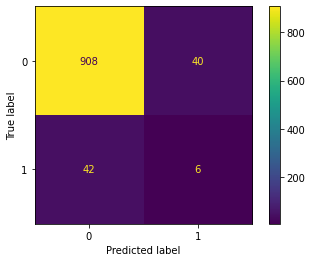

In [24]:
y_hat = model.predict(input_test)

print(f"The accuracy of this model is: {accuracy_score(label_test, y_hat):.2%}")
cm = confusion_matrix(label_test, y_hat)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

### Comparison

For the given data set, the baseline "most common class" is a very powerful classifier. That is, because the class `unemployed` is not strongly represented in the data. If this is generally true for the population, then it is fair enough to use this classifier.

The Linear Regression model performed poorly, as already suspected in the note above. One can see that the regression line is only capable of explaining 1.57% of the target variables variation.

In this case, the decision tree classifier's performance was weaker than the baseline. Nevertheless with more test data it could be that this classifier could generalize better, because it is unclear if the unbalanced class distribution is true.

### Did older employees have a higher risk of becoming unemployed during the financial crisis 2008/2009?

In [25]:
fig = px.histogram(employment, x="age", y="unemployed", nbins=5)
fig.show()

Answer: As it seems for the given data set, older people (age >= 60) had even a lower chance to become unemployed. As one sees only 19 employees above 60 became unemployed in comparison to 56 employees between 50 and 59 years.

# b)

### Read data

In [26]:
growth = pd.read_excel("dataset/Growth.xlsx")
growth.shape

/Users/lukaskubelka/Documents/_KIT/_Studium/_M.Sc./_Semester/Semester-2/PSDA/Uebungen/PSDA/.venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning:

Unknown extension is not supported and will be removed



(65, 8)

In [27]:
growth.head()

,country_name,growth,oil,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
0,India,1.915168,0,765.999817,0.140502,1.45,0.133333,0.866667
1,Argentina,0.617645,0,4462.001465,0.156623,4.99,0.933333,1.933333
2,Japan,4.304759,0,2953.999512,0.157703,6.71,0.000000,0.200000
3,Brazil,2.930097,0,1783.999878,0.160405,2.89,0.100000,0.100000
4,United States,1.712265,0,9895.003906,0.160815,8.66,0.000000,0.433333


The data set contains mainly continuous variables:
- the variables `growth`, `rgdp60`, `tradeshare`, `yearsschool`, `rev_coups` and `assassinations` are all real-valued

The variables `country_name` and `oil` are discrete:
- `county_name` is a categorical variable (irrelevant)
- `oil` is a binary variable

The target variable is `growth`

### Get familiar with data

In [28]:
growth.sort_values(by="assasinations", ascending=False).head()

,country_name,growth,oil,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
28,Guatemala,0.929231,0,1659.999756,0.509590,1.42,0.540741,2.466667
1,Argentina,0.617645,0,4462.001465,0.156623,4.99,0.933333,1.933333
30,El Salvador,-0.607556,0,1426.999878,0.527773,1.70,0.633333,1.733333
6,Spain,2.880327,0,3123.001465,0.299406,3.80,0.066667,1.433333
11,Italy,2.932981,0,4564.000488,0.330022,4.56,0.033333,1.200000


In [29]:
growth.sort_values(by="yearsschool", ascending=False).head()

,country_name,growth,oil,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
37,Denmark,2.179370,0,6759.999023,0.560750,10.07,0.0,0.000000
23,New Zealand,1.124132,0,7960.000977,0.455769,9.55,0.0,0.000000
10,Australia,1.975147,0,7782.002441,0.329479,9.03,0.0,0.066667
4,United States,1.712265,0,9895.003906,0.160815,8.66,0.0,0.433333
21,Canada,2.385988,0,7257.997070,0.444375,8.07,0.0,0.066667


In [30]:
growth[growth["country_name"] == "Germany"]

,country_name,growth,oil,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
20,Germany,2.453688,0,6569.998535,0.442143,7.64,0.066667,0.233333


### 1. Check if variable `oil` contains any information

In [31]:
growth["oil"].value_counts()

0    65
Name: oil, dtype: int64

All values of the variable `oil` are zero. That means it has to be dropped:

In [32]:
growth.drop(columns="oil", inplace=True)
growth.head()

,country_name,growth,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
0,India,1.915168,765.999817,0.140502,1.45,0.133333,0.866667
1,Argentina,0.617645,4462.001465,0.156623,4.99,0.933333,1.933333
2,Japan,4.304759,2953.999512,0.157703,6.71,0.000000,0.200000
3,Brazil,2.930097,1783.999878,0.160405,2.89,0.100000,0.100000
4,United States,1.712265,9895.003906,0.160815,8.66,0.000000,0.433333


### 2. Drop variable `country_name`, because it is not a good predictor

In [33]:
growth.drop(columns="country_name", inplace=True)
growth.head()

,growth,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
0,1.915168,765.999817,0.140502,1.45,0.133333,0.866667
1,0.617645,4462.001465,0.156623,4.99,0.933333,1.933333
2,4.304759,2953.999512,0.157703,6.71,0.000000,0.200000
3,2.930097,1783.999878,0.160405,2.89,0.100000,0.100000
4,1.712265,9895.003906,0.160815,8.66,0.000000,0.433333


### Choose target variable and regressors

In [34]:
y = growth["growth"]
X = growth.drop(columns="growth")

### Plot distribution of target variable

In [35]:
fig = px.histogram(growth, x=y, nbins=10)
fig.show()

In [36]:
fig = px.scatter_matrix(X)
fig.show()

### Drop `yearsschool` due to high correlation with `rgdp60`

In [37]:
growth.drop(columns="yearsschool", inplace=True)
growth.head()

,growth,rgdp60,tradeshare,rev_coups,assasinations
0,1.915168,765.999817,0.140502,0.133333,0.866667
1,0.617645,4462.001465,0.156623,0.933333,1.933333
2,4.304759,2953.999512,0.157703,0.000000,0.200000
3,2.930097,1783.999878,0.160405,0.100000,0.100000
4,1.712265,9895.003906,0.160815,0.000000,0.433333


### Possible methods

Possible regression methods are:

- ridge regression
- regression tree
- knn regression

Ridge Regression will be used, because the target variable could be assumed to be normal distributed given the other variables and it is generally a good idea to use a shrinkage model to prevent overfitting (likely to happen with this few training examples).

### Create training and test-split

In [38]:
input_train, input_test, target_train, target_test = train_test_split(X, y, shuffle=True, random_state=42)

### Baseline: Mean growth of all countries

In [39]:
avg_growth = target_train.mean()
model = lambda x: avg_growth
y_hat = input_test.apply(model, axis=1)
print(f"MSE of baseline is: {mean_squared_error(target_test, y_hat)}")

MSE of baseline is: 5.431124954587735


### Ridge Regression

Preprocessing: For ridge regression one has to standardize the features by removing the mean and scaling to unit variance.

In [40]:
input_train = StandardScaler().fit_transform(input_train)
input_test = StandardScaler().fit_transform(input_test)

In [41]:
model = linear_model.Ridge(alpha=0.1, random_state=42)
model.fit(input_train, target_train)

Ridge(alpha=0.1, random_state=42)

In [42]:
y_hat = model.predict(input_test)

print("MSE: ", mean_squared_error(target_test, y_hat))
print("R2: ", r2_score(target_test, y_hat))

MSE:  2.9758978115157113
R2:  0.355780843035295


### Evaluation

One can see that Ridge Regression fits the data better than the baseline.
The mean squared out-of-sample error of the ridge model is roughly 45% of the baseline's MSE.

Still, one can see that the used features only explain 35.57% of the target variable's variance (see R2 score).

# c)

### Read data

In [43]:
crabs = pd.read_csv("dataset/crabs.txt", header=None, delim_whitespace=True, names=["id", "color", "spine", "width", "weight", "satellites"], index_col=0)
crabs.shape

(173, 5)

In [44]:
crabs.head()

,color,spine,width,weight,satellites
id,,,,,
1,2,3,28.3,3.05,8
2,3,3,26.0,2.60,4
3,3,3,25.6,2.15,0
4,4,2,21.0,1.85,0
5,2,3,29.0,3.00,1


### Get familiar with data

In [45]:
crabs.sort_values(by="satellites", ascending=False).head()

,color,spine,width,weight,satellites
id,,,,,
101,2,3,28.3,3.00,15
48,2,1,26.0,2.30,14
159,4,3,29.3,3.23,12
133,2,3,28.2,3.05,11
61,2,3,29.0,3.20,10


The variables `width` and `height` are continuous variables.

The variables `color` and `spine` are discrete, categorical variables.
These two have to be dummy-transformed.

The discrete variable `satellites` is the target.
This is a regression task, despite the target variable being discrete.
That is, because the number of possible sattelites is not fixed.

### Dummy transform data

In [46]:
crabs = pd.get_dummies(crabs, columns=["color", "spine"], drop_first=True)
crabs.head()

,width,weight,satellites,color_2,color_3,color_4,spine_2,spine_3
id,,,,,,,,
1,28.3,3.05,8,1,0,0,0,1
2,26.0,2.60,4,0,1,0,0,1
3,25.6,2.15,0,0,1,0,0,1
4,21.0,1.85,0,0,0,1,1,0
5,29.0,3.00,1,1,0,0,0,1


### Choose target variable and inputs

In [47]:
y = crabs["satellites"]
X = crabs.drop(columns="satellites")

### Visualize target distribution

In [48]:
fig = px.histogram(crabs, x=y, nbins=10)
fig.show()

### Create train/test split

In [49]:
input_train, input_test, target_train, target_test = train_test_split(X, y, shuffle=True, random_state=42)

### Possible methods

Possible regression methods are:

- ridge regression
- regression tree
- knn regression

Regression tree will be used for comparison, because of the many binary variables.

### Baseline

In [50]:
model = linear_model.PoissonRegressor(alpha=0, max_iter=1000)
model.fit(input_train, target_train)

PoissonRegressor(alpha=0, max_iter=1000)

In [51]:
y_hat = model.predict(input_test)

print("MSE: ", mean_squared_error(target_test, y_hat))
print("R2: ", r2_score(target_test, y_hat))

MSE:  6.331471919972176
R2:  0.16879842428520142


### Regression tree

In [52]:
model = tree.DecisionTreeRegressor()
model.fit(input_train, target_train)

DecisionTreeRegressor()

In [53]:
y_hat = model.predict(input_test)

print("MSE: ", mean_squared_error(target_test, y_hat))

MSE:  21.414772727272727


### Evaluation:

One can see that the regression tree is performing pretty poorly in comparison to the baseline. Hyperparameter optimization is cruical for decision trees. It is very probable that the model is overfitting.

# d)

In [54]:
gasoline = pd.read_csv("dataset/gasoline.csv", sep=";", index_col=0, decimal=",")
gasoline.shape

(32, 6)

In [55]:
gasoline

,yield,gravity,pressure,temp10,temp,batch
1,0.122,50.8,8.6,190,205,1
2,0.223,50.8,8.6,190,275,1
3,0.347,50.8,8.6,190,345,1
4,0.457,50.8,8.6,190,407,1
5,0.080,40.8,3.5,210,218,2
6,0.131,40.8,3.5,210,273,2
7,0.266,40.8,3.5,210,347,2
8,0.074,40.0,6.1,217,212,3
9,0.182,40.0,6.1,217,272,3
10,0.304,40.0,6.1,217,340,3


The variables `yield`, `gravity` and `pressure` are continuous.

The variables `temp10` and `temp` are discrete.

The variable `batch` is a categorical variable.

In [56]:
fig = px.scatter(gasoline, y="yield", color="temp")
fig.show()

As one can clearly see in the scatter plot there are different subpopulations (aka `batch`) in the data within wich the variables `yield` and `temp` have roughly a linear relationship.

### Remove `batch` variable due to perfect correlation with `gravity`, `pressure` and `temp10`

In [57]:
gasoline.drop(columns="batch", inplace=True)
gasoline.head()

,yield,gravity,pressure,temp10,temp
1,0.122,50.8,8.6,190,205
2,0.223,50.8,8.6,190,275
3,0.347,50.8,8.6,190,345
4,0.457,50.8,8.6,190,407
5,0.080,40.8,3.5,210,218


## Choose target variable and inputs

In [58]:
y = gasoline["yield"]
X = gasoline.drop(columns="yield")

### Possible methods

Possible regression methods are:

- ridge regression
- regression tree
- knn regression

Ridge Regression will be used due to linear relationship as seen in plot above.

### Get train test split

In [59]:
input_train, input_test, target_train, target_test = train_test_split(X, y, shuffle=True, random_state=42)

### Baseline

In [60]:
model = BetaModel(y, X).fit()

/Users/lukaskubelka/Documents/_KIT/_Studium/_M.Sc./_Semester/Semester-2/PSDA/Uebungen/PSDA/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:2694: UserWarning:

df_model + k_constant differs from nparams



In [61]:
y_hat = model.predict(input_test)

print("MSE: ", mean_squared_error(target_test, y_hat))

MSE:  0.0009687571203495709


### Ridge Regression

In [62]:
input_train = StandardScaler().fit_transform(input_train)
input_test = StandardScaler().fit_transform(input_test)

In [63]:
model = linear_model.Ridge(alpha=0.1, random_state=42)
model.fit(input_train, target_train)

Ridge(alpha=0.1, random_state=42)

In [64]:
y_hat = model.predict(input_test)

print("MSE: ", mean_squared_error(target_test, y_hat))
print("R2: ", r2_score(target_test, y_hat))

MSE:  0.0052749323027206155
R2:  0.2257832454818749


### Comparison:

Both models fit the data virtually perfectly (MSE is next to zero).